# Pekka ja susi: Johdatus vahvistusoppimiseen

Tässä opetusohjelmassa opimme soveltamaan vahvistusoppimista reitinetsintäongelmaan. Asetelma on saanut inspiraationsa venäläisen säveltäjän [Sergei Prokofjevin](https://en.wikipedia.org/wiki/Sergei_Prokofiev) musiikkisadusta [Pekka ja susi](https://en.wikipedia.org/wiki/Peter_and_the_Wolf). Tarina kertoo nuoresta pioneeri Pekasta, joka rohkeasti lähtee talostaan metsän aukealle jahtamaan sutta. Me koulutamme koneoppimisalgoritmeja, jotka auttavat Pekkaa tutkimaan ympäröivää aluetta ja rakentamaan optimaalisen navigointikartan.

Aloitetaan ensin tuomalla joukko hyödyllisiä kirjastoja:


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

## Yleiskatsaus vahvistusoppimiseen

**Vahvistusoppiminen** (RL) on oppimistekniikka, jonka avulla voidaan oppia **agentin** optimaalinen käyttäytyminen jossakin **ympäristössä** suorittamalla lukuisia kokeita. Agentilla tässä ympäristössä tulisi olla jokin **tavoite**, joka määritellään **palkintofunktion** avulla.

## Ympäristö

Yksinkertaisuuden vuoksi tarkastellaan Peterin maailmaa, joka on neliölauta kooltaan `width` x `height`. Jokainen ruutu tässä laudassa voi olla:
* **maa**, jolla Peter ja muut olennot voivat kävellä
* **vesi**, jolla ei tietenkään voi kävellä
* **puu** tai **ruoho** - paikka, jossa voi levätä
* **omena**, joka edustaa jotain, mitä Peter mielellään löytäisi ravinnokseen
* **susi**, joka on vaarallinen ja tulisi välttää

Ympäristön kanssa työskentelyä varten määrittelemme luokan nimeltä `Board`. Jotta emme täyttäisi tätä muistikirjaa liikaa, olemme siirtäneet kaiken laudan kanssa työskentelyyn liittyvän koodin erilliseen `rlboard`-moduuliin, jonka nyt tuomme käyttöön. Voit tarkastella tätä moduulia saadaksesi lisätietoja toteutuksen sisäisistä yksityiskohdista.


In [2]:
from rlboard import *

Luodaan nyt satunnainen pelilauta ja katsotaan, miltä se näyttää:


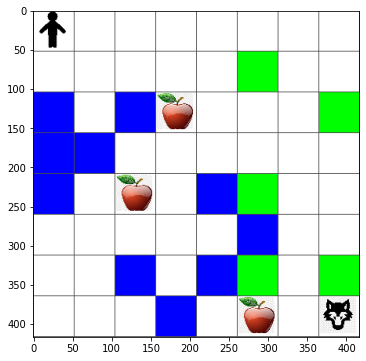

In [3]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

## Toiminnot ja Säännöt

Esimerkissämme Peterin tavoitteena on löytää omena samalla välttäen sutta ja muita esteitä. Tämän saavuttamiseksi hän voi käytännössä kävellä ympäriinsä, kunnes löytää omenan. Näin ollen missä tahansa sijainnissa hän voi valita yhden seuraavista toiminnoista: ylös, alas, vasemmalle ja oikealle. Määrittelemme nämä toiminnot sanakirjana ja yhdistämme ne vastaaviin koordinaattimuutosten pareihin. Esimerkiksi oikealle liikkuminen (`R`) vastaisi paria `(1,0)`.


In [4]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

Agenttimme (Peter) strategia määritellään niin sanotulla **politiikalla**. Tarkastellaan yksinkertaisinta politiikkaa, jota kutsutaan **satunnaiseksi kävelyksi**.

## Satunnainen kävely

Ratkaistaan ensin ongelmamme toteuttamalla satunnaisen kävelyn strategia.


In [5]:
def random_policy(m):
    return random.choice(list(actions))

def walk(m,policy,start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position 
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1 # eaten by wolf or drowned
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human,a)
            if m.is_valid(new_pos) and m.at(new_pos)!=Board.Cell.water:
                m.move(a) # do the actual move
                break
        n+=1

walk(m,random_policy)

18

Suoritetaan satunnaiskävelykokeilu useita kertoja ja katsotaan otettujen askelten keskimääräinen määrä:


In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        else:
            s += z
            n += 1
    print(f"Average path length = {s/n}, eaten by wolf: {w} times")

print_statistics(random_policy)

Average path length = 32.87096774193548, eaten by wolf: 7 times


## Palkkiofunktio

Jotta voimme tehdä politiikastamme älykkäämmän, meidän on ymmärrettävä, mitkä siirrot ovat "parempia" kuin toiset.


In [7]:
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m,pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x==Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x==Board.Cell.apple:
        return goal_reward
    return move_reward

## Q-oppiminen

Luo Q-taulukko eli monidimensioinen taulukko. Koska laudallamme on mitat `width` x `height`, voimme esittää Q-taulukon numpy-taulukkona, jonka muoto on `width` x `height` x `len(actions)`:


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

Anna Q-taulukko plot-funktiolle, jotta taulukko voidaan visualisoida laudalla:


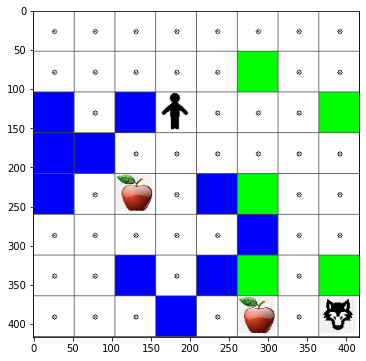

In [9]:
m.plot(Q)

## Q-Learningin ydin: Bellmanin yhtälö ja oppimisalgoritmi

Kirjoita pseudokoodi oppimisalgoritmillemme:

* Alusta Q-taulukko Q samoilla arvoilla kaikille tiloille ja toimille
* Aseta oppimisnopeus $\alpha\leftarrow 1$
* Toista simulaatio monta kertaa
   1. Aloita satunnaisesta sijainnista
   1. Toista
        1. Valitse toiminto $a$ tilassa $s$
        2. Suorita toiminto siirtymällä uuteen tilaan $s'$
        3. Jos kohtaamme pelin loppuehdon tai kokonaispalkkio on liian pieni - lopeta simulaatio  
        4. Laske palkkio $r$ uudessa tilassa
        5. Päivitä Q-funktio Bellmanin yhtälön mukaan: $Q(s,a)\leftarrow (1-\alpha)Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a'))$
        6. $s\leftarrow s'$
        7. Päivitä kokonaispalkkio ja pienennä $\alpha$.

## Hyödyntäminen vs. Tutkiminen

Paras lähestymistapa on tasapainottaa tutkimisen ja hyödyntämisen välillä. Kun opimme enemmän ympäristöstämme, olemme todennäköisemmin seuraamassa optimaalista reittiä, mutta valitsemme silloin tällöin tutkimattoman polun.

## Python-toteutus

Nyt olemme valmiita toteuttamaan oppimisalgoritmin. Ennen sitä tarvitsemme myös funktion, joka muuntaa Q-taulukon satunnaiset numerot todennäköisyysvektoriksi vastaaville toiminnoille:


In [10]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

Lisäämme pienen määrän `eps` alkuperäiseen vektoriin välttääksemme jakamisen nollalla alkuvaiheessa, kun kaikki vektorin komponentit ovat identtisiä.

Varsinainen oppimisalgoritmi, jota suoritamme 5000 kokeessa, kutsutaan myös **epookeiksi**:


In [11]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    m.random_start()
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        dpos = actions[a]
        m.move(dpos,check_correctness=False) # we allow player to move outside the board, which terminates episode
        r = reward(m)
        cum_reward += r
        if r==end_reward or cum_reward < -1000:
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

Suoritettuaan tämän algoritmin Q-taulukon pitäisi päivittyä arvoilla, jotka määrittävät eri toimien houkuttelevuuden kussakin vaiheessa. Visualisoi taulukko tässä:


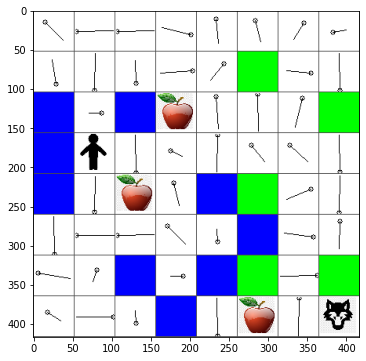

In [12]:
m.plot(Q)

## Politiikan tarkistaminen

Koska Q-taulukko listaa kunkin toiminnon "houkuttelevuuden" jokaisessa tilassa, sen avulla on melko helppoa määritellä tehokas navigointi maailmassamme. Yksinkertaisimmassa tapauksessa voimme vain valita toiminnon, joka vastaa korkeinta Q-taulukon arvoa:


In [13]:
def qpolicy_strict(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = list(actions)[np.argmax(v)]
        return a

walk(m,qpolicy_strict)

2

Jos kokeilet yllä olevaa koodia useita kertoja, saatat huomata, että se joskus vain "jumittuu", ja sinun täytyy painaa STOP-painiketta keskeyttääksesi sen.

> **Tehtävä 1:** Muokkaa `walk`-funktiota rajoittamaan polun maksimipituus tiettyyn askelmäärään (esimerkiksi 100), ja katso, kuinka yllä oleva koodi palauttaa tämän arvon ajoittain.

> **Tehtävä 2:** Muokkaa `walk`-funktiota niin, ettei se palaa paikkoihin, joissa se on jo aiemmin käynyt. Tämä estää `walk`-funktion joutumasta silmukkaan, mutta agentti voi silti päätyä "jumiin" paikkaan, josta se ei pysty pakenemaan.


In [14]:

def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Average path length = 3.45, eaten by wolf: 0 times


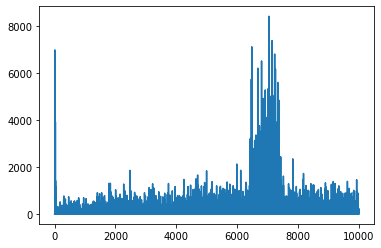

In [15]:
plt.plot(lpath)

Mitä näemme tässä, on että aluksi keskimääräinen polun pituus kasvoi. Tämä johtuu todennäköisesti siitä, että kun emme tiedä mitään ympäristöstä, olemme todennäköisesti jumissa huonoissa tiloissa, kuten vedessä tai suden luona. Kun opimme lisää ja alamme käyttää tätä tietoa, voimme tutkia ympäristöä pidempään, mutta emme silti tiedä hyvin, missä omenat sijaitsevat.

Kun opimme tarpeeksi, agentin on helpompi saavuttaa tavoite, ja polun pituus alkaa lyhentyä. Olemme kuitenkin edelleen avoimia tutkimiselle, joten poikkeamme usein parhaasta polusta ja tutkimme uusia vaihtoehtoja, mikä tekee polusta pidemmän kuin optimaalinen.

Mitä myös huomaamme tästä graafista, on että jossain vaiheessa pituus kasvoi äkillisesti. Tämä viittaa prosessin satunnaiseen luonteeseen ja siihen, että voimme jossain vaiheessa "pilata" Q-taulukon kertoimet korvaamalla ne uusilla arvoilla. Tämä tulisi ihanteellisesti minimoida pienentämällä oppimisnopeutta (eli koulutuksen loppuvaiheessa säädämme Q-taulukon arvoja vain pienellä määrällä).

Kaiken kaikkiaan on tärkeää muistaa, että oppimisprosessin onnistuminen ja laatu riippuvat merkittävästi parametreista, kuten oppimisnopeudesta, oppimisnopeuden vähenemisestä ja diskonttokertoimesta. Näitä kutsutaan usein **hyperparametreiksi**, jotta ne erotetaan **parametreista**, joita optimoimme koulutuksen aikana (esim. Q-taulukon kertoimet). Parhaiden hyperparametriarvojen löytämistä kutsutaan **hyperparametrien optimoinniksi**, ja se ansaitsee oman aiheensa.


## Harjoitus
#### Realistisempi Peter ja susi -maailma

Meidän tilanteessamme Peter pystyi liikkumaan lähes väsymättä tai tuntematta nälkää. Realistisemmassa maailmassa hänen täytyy välillä istua alas ja levätä, sekä syödä pitääkseen itsensä kunnossa. Tehdään maailmastamme realistisempi toteuttamalla seuraavat säännöt:

1. Liikkuessaan paikasta toiseen Peter menettää **energiaa** ja kerää **väsymystä**.
2. Peter voi saada lisää energiaa syömällä omenoita.
3. Peter voi päästä eroon väsymyksestä lepäämällä puun alla tai ruohikolla (eli siirtymällä pelilaudan kohtaan, jossa on puu tai ruoho - vihreä alue).
4. Peterin täytyy löytää ja tappaa susi.
5. Tappaakseen suden Peterillä täytyy olla tietyt energian ja väsymyksen tasot, muuten hän häviää taistelun.

Muokkaa yllä olevaa palkkiofunktiota pelin sääntöjen mukaisesti, aja vahvistusoppimisalgoritmi oppiaksesi parhaan strategian pelin voittamiseen, ja vertaa satunnaiskävelyn tuloksia algoritmisi tuloksiin pelien voittamisen ja häviämisen määrän osalta.

> **Huomio**: Saatat joutua säätämään hyperparametreja, jotta algoritmi toimii, erityisesti epochien määrää. Koska pelin onnistuminen (suden kohtaaminen) on harvinainen tapahtuma, voit odottaa huomattavasti pidempää koulutusaikaa.



---

**Vastuuvapauslauseke**:  
Tämä asiakirja on käännetty käyttämällä tekoälypohjaista käännöspalvelua [Co-op Translator](https://github.com/Azure/co-op-translator). Vaikka pyrimme tarkkuuteen, huomioithan, että automaattiset käännökset voivat sisältää virheitä tai epätarkkuuksia. Alkuperäistä asiakirjaa sen alkuperäisellä kielellä tulee pitää ensisijaisena lähteenä. Kriittisen tiedon osalta suositellaan ammattimaista ihmiskääntämistä. Emme ole vastuussa tämän käännöksen käytöstä aiheutuvista väärinkäsityksistä tai virhetulkinnoista.
